In [46]:
import pandas as pd
import joblib 
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np



In [26]:
df = pd.read_csv("Mental Health Dataset.csv")

In [27]:
df.head(5)

,Timestamp,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
0,8/27/2014 11:29,Female,United States,Corporate,NaN,No,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Not sure
1,8/27/2014 11:31,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,No
2,8/27/2014 11:32,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes
3,8/27/2014 11:37,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,Maybe,Yes
4,8/27/2014 11:43,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes


In [28]:
columns_to_drop = ['Timestamp', 'Country', 'Occupation']
df.drop(columns=columns_to_drop, inplace=True)

In [29]:
df.tail(5)

,Gender,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
292359,Male,Yes,Yes,Yes,15-30 days,No,Maybe,No,Low,Yes,No,Maybe,Maybe,Not sure
292360,Male,No,Yes,Yes,15-30 days,No,Maybe,No,Low,Yes,No,Maybe,No,Yes
292361,Male,No,Yes,No,15-30 days,No,Maybe,No,Low,Yes,No,Maybe,No,No
292362,Male,No,Yes,Yes,15-30 days,No,Maybe,No,Low,Yes,No,Maybe,No,Yes
292363,Male,No,Yes,Yes,15-30 days,No,Maybe,No,Low,Yes,No,Maybe,No,Yes


In [30]:
print (df.isna())

        Gender  self_employed  family_history  treatment  Days_Indoors  \
0        False           True           False      False         False   
1        False           True           False      False         False   
2        False           True           False      False         False   
3        False          False           False      False         False   
4        False          False           False      False         False   
...        ...            ...             ...        ...           ...   
292359   False          False           False      False         False   
292360   False          False           False      False         False   
292361   False          False           False      False         False   
292362   False          False           False      False         False   
292363   False          False           False      False         False   

        Growing_Stress  Changes_Habits  Mental_Health_History  Mood_Swings  \
0                False           

In [31]:
print (df.isna().sum())

Gender                        0
self_employed              5202
family_history                0
treatment                     0
Days_Indoors                  0
Growing_Stress                0
Changes_Habits                0
Mental_Health_History         0
Mood_Swings                   0
Coping_Struggles              0
Work_Interest                 0
Social_Weakness               0
mental_health_interview       0
care_options                  0
dtype: int64


In [32]:
mode_self_employed = df['self_employed'].mode()[0]
df['self_employed'] = df['self_employed'].fillna(mode_self_employed)

In [33]:
print (df.isna().sum())

Gender                     0
self_employed              0
family_history             0
treatment                  0
Days_Indoors               0
Growing_Stress             0
Changes_Habits             0
Mental_Health_History      0
Mood_Swings                0
Coping_Struggles           0
Work_Interest              0
Social_Weakness            0
mental_health_interview    0
care_options               0
dtype: int64


In [34]:
risk_mappings = {
    'family_history': {'Yes': 1, 'No': 0}, 'treatment': {'Yes': 1, 'No': 0},
    'Growing_Stress': {'Yes': 1, 'No': 0}, 'Changes_Habits': {'Yes': 1, 'No': 0},
    'Mental_Health_History': {'Yes': 1, 'No': 0}, 'Coping_Struggles': {'Yes': 1, 'No': 0},
    'Social_Weakness': {'Yes': 1, 'No': 0}, 'mental_health_interview': {'Yes': 1, 'Maybe': 0.5, 'No': 0},
    'Work_Interest': {'No': 1, 'Yes': 0},
    'Days_Indoors': {'1-14 days': 0, '15-30 days': 1, '2-4 weeks': 2, '4-8 weeks': 3, 'More than 2 months': 4},
    'Mood_Swings': {'Low': 0, 'Medium': 1, 'High': 2},
    'care_options': {'No': 1, 'Not sure': 0.5, 'Yes': 0}
}

In [35]:
RISK_MAPPING_DICT = {"Low Risk": 0, "Stable": 1, "High Risk": 2}

In [36]:
df['Risk_Score'] = 0
for col, mapping in risk_mappings.items():
    df['Risk_Score'] += df[col].map(mapping).fillna(0)

In [37]:
max_score = df['Risk_Score'].max()
low_risk_threshold = max_score * 0.2
high_risk_threshold = max_score * 0.5

def categorize_risk(score):
    if score >= high_risk_threshold:
        return 'High Risk'
    elif score > low_risk_threshold:
        return 'Stable'
    else:
        return 'Low Risk'



In [38]:
# Apply categorization to create the final numerical Target variable
df['Mental_State_Category'] = df['Risk_Score'].apply(categorize_risk)
RISK_MAPPING_DICT = {"Low Risk": 0, "Stable": 1, "High Risk": 2}

In [39]:
df['Target'] = df['Mental_State_Category'].map(RISK_MAPPING_DICT)

In [40]:
df.dropna(subset=['Target'], inplace=True)

In [41]:
feature_cols = [
    'Gender', 'self_employed', 'family_history', 'treatment', 'Days_Indoors',
    'Growing_Stress', 'Changes_Habits', 'Mental_Health_History', 'Mood_Swings',
    'Coping_Struggles', 'Work_Interest', 'Social_Weakness', 'mental_health_interview',
    'care_options'
]

X = df[feature_cols]
y = df['Target'].values.astype(int)
X_encoded = pd.get_dummies(X, drop_first=True)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42, stratify=y)

In [43]:
custom_weights = 'balanced'
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=8,  # Reduced max_depth from 10 to 8 for more regularization
    min_samples_leaf=5, # Added min_samples_leaf to prevent overly specific splits
    random_state=42, 
    class_weight=custom_weights 
)
rf_model.fit(X_train, y_train)



RandomForestClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=5,
                       random_state=42)

In [44]:
# Display the fitted model (output for the cell)
print(rf_model)

RandomForestClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=5,
                       random_state=42)


In [47]:
# Make predictions on the test data
y_pred_rf = rf_model.predict(X_test)

# Map numerical labels in the report back to string names for clarity
target_names = list(RISK_MAPPING_DICT.keys())

# Generate the classification report
report_rf = classification_report(
    y_test, y_pred_rf, 
    target_names=target_names, 
    output_dict=True
)

In [48]:
# Display final report using the correct variable: report_rf
print("\n=======================================================")
print("  FINAL MODEL PERFORMANCE (Random Forest with Custom Class Weights)")
print("=======================================================")

print("\nPerformance Metrics:")
print(pd.DataFrame(report_rf).transpose().to_markdown(numalign="left", stralign="left"))


  FINAL MODEL PERFORMANCE (Random Forest with Custom Class Weights)

Performance Metrics:
|              | precision   | recall   | f1-score   | support   |
|:-------------|:------------|:---------|:-----------|:----------|
| Low Risk     | 0.531542    | 0.988165 | 0.691253   | 6506      |
| Stable       | 0.949722    | 0.844141 | 0.893824   | 55518     |
| High Risk    | 0.886292    | 0.906408 | 0.896237   | 25686     |
| accuracy     | 0.873059    | 0.873059 | 0.873059   | 0.873059  |
| macro avg    | 0.789185    | 0.912905 | 0.827105   | 87710     |
| weighted avg | 0.900128    | 0.873059 | 0.879505   | 87710     |


risk_score_distribution_and_thresholds.png


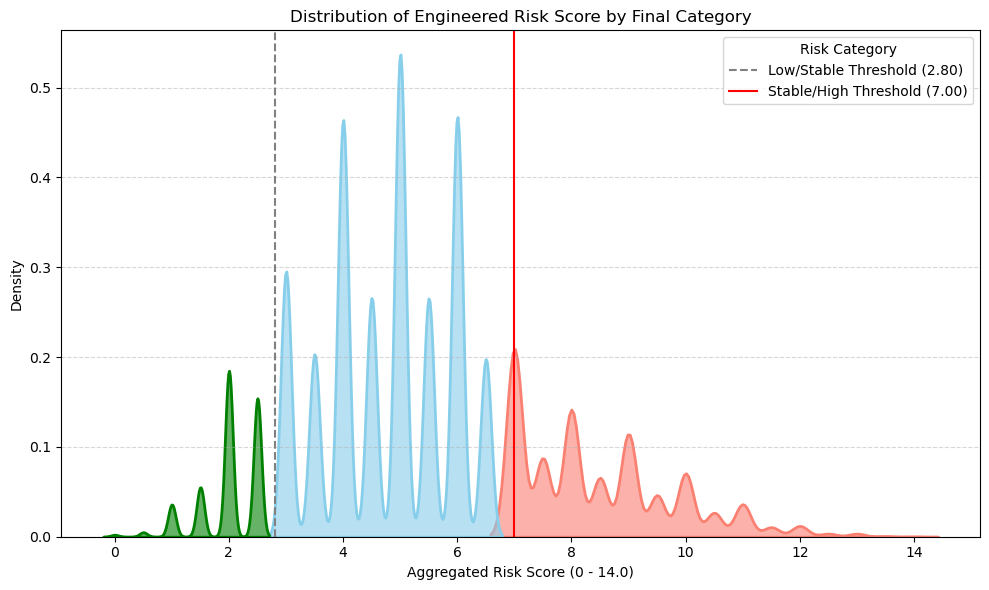

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Preparation & Feature Engineering (To create the target variable) ---

df = pd.read_csv("Mental Health Dataset.csv")

# 1. Handle missing values for 'self_employed' 
mode_self_employed = df['self_employed'].mode()[0]
# Using direct assignment to ensure no chained assignment/NaN issues
df['self_employed'] = df['self_employed'].fillna(mode_self_employed) 

# 2. Drop Irrelevant Columns
columns_to_drop = ['Timestamp', 'Country', 'Occupation']
df.drop(columns=columns_to_drop, inplace=True)

# 3. Define risk scoring Mappings 
risk_mappings = {
    'family_history': {'Yes': 1, 'No': 0}, 'treatment': {'Yes': 1, 'No': 0},
    'Growing_Stress': {'Yes': 1, 'No': 0}, 'Changes_Habits': {'Yes': 1, 'No': 0},
    'Mental_Health_History': {'Yes': 1, 'No': 0}, 'Coping_Struggles': {'Yes': 1, 'No': 0},
    'Social_Weakness': {'Yes': 1, 'No': 0}, 'mental_health_interview': {'Yes': 1, 'Maybe': 0.5, 'No': 0},
    'Work_Interest': {'No': 1, 'Yes': 0},
    'Days_Indoors': {'1-14 days': 0, '15-30 days': 1, '2-4 weeks': 2, '4-8 weeks': 3, 'More than 2 months': 4},
    'Mood_Swings': {'Low': 0, 'Medium': 1, 'High': 2},
    'care_options': {'No': 1, 'Not sure': 0.5, 'Yes': 0}
}

# 4. Calculate Risk_Score and Create Target Variable
df['Risk_Score'] = 0
for col, mapping in risk_mappings.items():
    df['Risk_Score'] += df[col].map(mapping).fillna(0)

max_score = df['Risk_Score'].max()
low_risk_threshold = max_score * 0.2
high_risk_threshold = max_score * 0.5

def categorize_risk(score):
    if score >= high_risk_threshold:
        return 'High Risk'
    elif score > low_risk_threshold:
        return 'Stable'
    else:
        return 'Low Risk'

df['Mental_State_Category'] = df['Risk_Score'].apply(categorize_risk)

# --- Plotting the Risk Score Distribution with Categories ---

# Define a color palette for visualization
palette = {'Low Risk': 'green', 'Stable': 'skyblue', 'High Risk': 'salmon'}

plt.figure(figsize=(10, 6))

# Plot the distribution of the Risk Score, colored by the Category
sns.kdeplot(data=df, x='Risk_Score', hue='Mental_State_Category', 
            palette=palette, fill=True, alpha=0.6, linewidth=2, 
            hue_order=['Low Risk', 'Stable', 'High Risk'])

# Add vertical lines for the defined thresholds
plt.axvline(low_risk_threshold, color='gray', linestyle='--', label=f'Low/Stable Threshold ({low_risk_threshold:.2f})')
plt.axvline(high_risk_threshold, color='red', linestyle='-', label=f'Stable/High Threshold ({high_risk_threshold:.2f})')

# Add labels and title
plt.title('Distribution of Engineered Risk Score by Final Category')
plt.xlabel('Aggregated Risk Score (0 - 14.0)')
plt.ylabel('Density')
plt.legend(title='Risk Category')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Save the plot
plt.tight_layout()
plt.savefig('risk_score_distribution_and_thresholds.png')
print("risk_score_distribution_and_thresholds.png")

In [50]:
# --- 3. Save the Model ---
joblib.dump(rf_model, 'rf_model.joblib')

print("Files created successfully: rf_model.joblib and encoded_features.json")

Files created successfully: rf_model.joblib and encoded_features.json


In [51]:
import os
print("Current Working Directory:", os.getcwd())

Current Working Directory: C:\Users\ndira\app\Final year


In [52]:
import pandas as pd
import json
import os
import sys # Include sys for clean exit

def generate_and_save_encoded_features():
    """
    Loads data, performs necessary feature engineering (OHE),
    and saves the list of column names to a JSON file.
    """
    
    OUTPUT_FILENAME = 'encoded_features.json'
    
    # Define the output path in the current working directory
    try:
        OUTPUT_PATH = os.path.join(os.getcwd(), OUTPUT_FILENAME)
    except Exception:
        # Fallback if os.getcwd() fails for some reason
        print("ERROR: Could not determine current working directory. Exiting.")
        return

    try:
        # --- 1. Data Preparation & Feature Engineering (Consistent with API) ---
        
        df = pd.read_csv("Mental Health Dataset.csv")
        
        # Handle missing values for 'self_employed'
        mode_self_employed = df['self_employed'].mode()[0]
        df['self_employed'] = df['self_employed'].fillna(mode_self_employed) 

        # Drop irrelevant metadata columns
        columns_to_drop = ['Timestamp', 'Country', 'Occupation']
        df = df.drop(columns=columns_to_drop)

        # --- 2. Define Features (X) and Generate Encoded Features ---
        
        feature_cols = [
            'Gender', 'self_employed', 'family_history', 'treatment', 'Days_Indoors',
            'Growing_Stress', 'Changes_Habits', 'Mental_Health_History', 'Mood_Swings',
            'Coping_Struggles', 'Work_Interest', 'Social_Weakness', 'mental_health_interview',
            'care_options'
        ]
        X = df[feature_cols]

        # Apply the One-Hot Encoding (OHE) exactly as the model was trained
        X_encoded = pd.get_dummies(X, drop_first=True)

        # Generate the list of final column names
        encoded_features = list(X_encoded.columns)


        # --- 3. Save the List to the Specified Path ---

        with open(OUTPUT_PATH, 'w') as f:
            json.dump(encoded_features, f)
        
        print("=====================================================")
        print("SUCCESS: The file 'encoded_features.json' has been created.")
        print(f"File saved at: {os.path.dirname(OUTPUT_PATH)}")
        print(f"Total encoded features: {len(encoded_features)}")
        print("=====================================================")

    except Exception as e:
        print("\n=====================================================")
        print(f"CRITICAL FILE ERROR: Could not save/process file. Reason: {e}")
        print("POSSIBLE CAUSE: 'Mental Health Dataset.csv' is missing or permissions denied.")
        print("=====================================================")

# Execute the function
if __name__ == "__main__":
    generate_and_save_encoded_features()

SUCCESS: The file 'encoded_features.json' has been created.
File saved at: C:\Users\ndira\app\Final year
Total encoded features: 25
